In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

2025-04-08 09:31:01.349918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744104661.371302  843871 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744104661.377666  843871 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 09:31:01.399456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def load_prot_t5_data(pos_file, neg_file):
    """Load ProtT5 embeddings and align with existing data"""
    # Read positive and negative files
    pos_data = []
    with open(pos_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            pos_data.append((entry, pos, embeddings))
            
    neg_data = []
    with open(neg_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            neg_data.append((entry, pos, embeddings))
    
    # Convert to dictionaries for easy lookup
    pos_dict = {(entry, pos): emb for entry, pos, emb in pos_data}
    neg_dict = {(entry, pos): emb for entry, pos, emb in neg_data}
    
    return pos_dict, neg_dict

In [4]:
def prepare_aligned_data(seq_struct_df, pos_dict, neg_dict):
    """Align ProtT5 embeddings with sequence+structure data"""
    embeddings = []
    aligned_indices = []
    
    for idx, row in seq_struct_df.iterrows():
        key = (row['entry'], row['pos'])
        emb = pos_dict.get(key) if row['label'] == 1 else neg_dict.get(key)
        
        if emb is not None:
            embeddings.append(emb)
            aligned_indices.append(idx)
    
    # Convert to numpy array
    X_prot_t5 = np.array(embeddings)
    
    # Get aligned sequence+structure data
    aligned_df = seq_struct_df.iloc[aligned_indices]
    
    return X_prot_t5, aligned_df

In [5]:
def mirror_sequence(seq, window_size=33):
    """
    Mirror the sequence for padding positions on either left or right side
    window_size: total size of the window (should be odd number)
    """
    half_window = window_size // 2
    seq_list = list(seq)
    center = half_window  # K position
    
    # Check if padding is on the left side (N-terminus)
    if '-' in seq_list[:half_window]:
        left_valid = seq_list[:center]  # Get valid sequence up to K
        left_valid = [x for x in left_valid if x != '-']  # Remove padding
        needed_padding = half_window - len(left_valid)
        # Mirror from right side of K
        mirror_source = seq_list[center+1:center+1+needed_padding]
        mirror_source = mirror_source[::-1]  # Reverse the sequence
        seq_list[:needed_padding] = mirror_source
        
    # Check if padding is on the right side (C-terminus)
    elif '-' in seq_list[half_window+1:]:
        right_valid = seq_list[center+1:]  # Get valid sequence after K
        right_valid = [x for x in right_valid if x != '-']  # Remove padding
        needed_padding = half_window - len(right_valid)
        # Mirror from left side of K
        mirror_source = seq_list[center-needed_padding:center]
        mirror_source = mirror_source[::-1]  # Reverse the sequence
        seq_list[-needed_padding:] = mirror_source
    
    return ''.join(seq_list)

In [6]:
from Bio import SeqIO

def get_input_for_embedding(fasta_file):
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        # Apply mirroring before encoding
        mirrored_seq = mirror_sequence(data)
        for char in mirrored_seq:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in mirrored_seq]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

In [7]:
def create_sequence_model():
    """Create CNN model for sequence data"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(33,)),
        tf.keras.layers.Embedding(21, 21, input_length=33),
        tf.keras.layers.Reshape((33, 21, 1)),
        tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [8]:
def print_metrics(y_true, y_pred):
    """
    Print comprehensive evaluation metrics
    
    Parameters:
    y_true: array-like of true labels
    y_pred: array-like of predicted labels
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    sensitivity = cm[1][1] / (cm[1][1] + cm[1][0])  # True Positive Rate
    specificity = cm[0][0] / (cm[0][0] + cm[0][1])  # True Negative Rate
    
    # Print results
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("Confusion Matrix:")
    print(cm)

In [ ]:
def train_and_evaluate_seq_only():
    """Training function for sequence-only model using FASTA files"""
    # Load data from FASTA files
    print("Loading data from FASTA files...")
    train_positive_embedding = get_input_for_embedding('../../../data/train/fasta/positive_sites.fasta')
    train_negative_embedding = get_input_for_embedding('../../../data/train/fasta/negative_sites.fasta')
    test_positive_embedding = get_input_for_embedding('../../../data/test/fasta/test_positive_sites.fasta')
    test_negative_embedding = get_input_for_embedding('../../../data/test/fasta/test_negative_sites.fasta')
    
    # Check if any of the files couldn't be loaded
    if train_positive_embedding is None or train_negative_embedding is None or \
       test_positive_embedding is None or test_negative_embedding is None:
        print("Error: Could not load one or more FASTA files. Check for non-standard amino acids.")
        return
    
    # Create labels for positive and negative samples
    train_positive_labels = np.ones(len(train_positive_embedding))
    train_negative_labels = np.zeros(len(train_negative_embedding))
    test_positive_labels = np.ones(len(test_positive_embedding))
    test_negative_labels = np.zeros(len(test_negative_embedding))
    
    # Combine positive and negative samples
    X_train_seq = np.vstack((train_positive_embedding, train_negative_embedding))
    y_train = np.concatenate((train_positive_labels, train_negative_labels))
    
    X_test_seq = np.vstack((test_positive_embedding, test_negative_embedding))
    y_test = np.concatenate((test_positive_labels, test_negative_labels))
    
    # Shuffle training data
    shuffle_idx = np.random.RandomState(42).permutation(len(y_train))
    X_train_seq = X_train_seq[shuffle_idx]
    y_train = y_train[shuffle_idx]
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    print(f"Training data shape: {X_train_seq.shape}")
    print(f"Testing data shape: {X_test_seq.shape}")
    print(f"Class weights: {class_weights}")
    
    # Cross-validation setup
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq, y_train), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_sequence_model()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            X_train_seq[train_idx], 
            y_train[train_idx],
            validation_data=(
                X_train_seq[val_idx], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        val_pred = model.predict(X_train_seq[val_idx])
        val_pred_binary = (val_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], val_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], val_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], val_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], val_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Predict on test set
        test_pred = model.predict(X_test_seq)
        test_predictions.append(test_pred)
        
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model, test_pred_avg

Loading data from FASTA files...
Training data shape: (9500, 33)
Testing data shape: (3224, 33)
Class weights: {0: 1.0, 1: 1.0}

Fold 1/5


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1744104664.365395  843871 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 503 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0


Epoch 1/50


2025-04-08 09:31:05.133583: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}
E0000 00:00:1744104666.001158  843871 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:174410

238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5010 - loss: 0.6926 - val_accuracy: 0.6142 - val_loss: 0.6523 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6288 - loss: 0.6334 - val_accuracy: 0.6947 - val_loss: 0.5799 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7146 - loss: 0.5688 - val_accuracy: 0.7279 - val_loss: 0.5507 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7395 - loss: 0.5389 - val_accuracy: 0.7363 - val_loss: 0.5424 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7446 - loss: 0.5247 - val_accuracy: 0.7321 - val_loss: 0.5339 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7633 - loss: 0.5114 - val_accuracy: 0.7332 - val_loss: 0.5322 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7696 - loss: 0.5002 - val_accurac

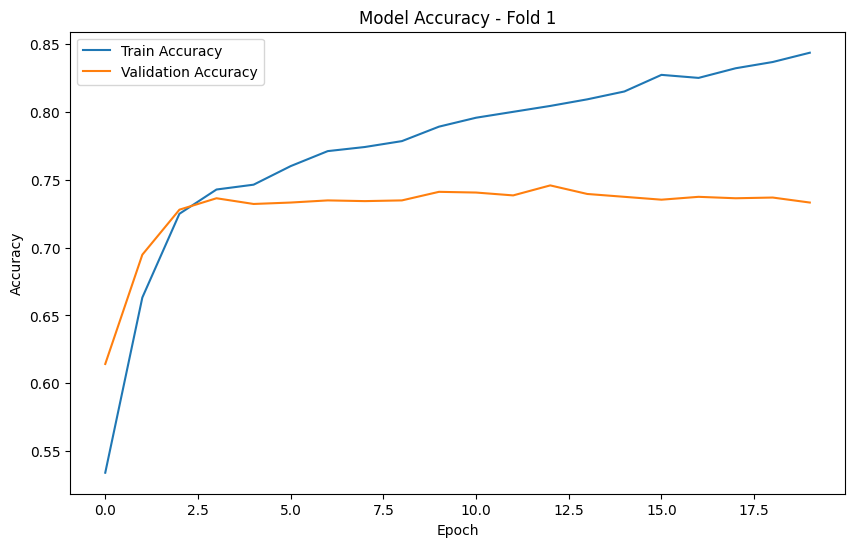

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-04-08 09:31:32.729801: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 1 Results:
Accuracy: 0.7411
Balanced Accuracy: 0.7411
MCC: 0.4825
Sensitivity: 0.7600
Specificity: 0.7221

Fold 2/5
Epoch 1/50


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5190 - loss: 0.6924 - val_accuracy: 0.6305 - val_loss: 0.6572 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6332 - loss: 0.6458 - val_accuracy: 0.6895 - val_loss: 0.5973 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6948 - loss: 0.5966 - val_accuracy: 0.7232 - val_loss: 0.5528 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7205 - loss: 0.5498 - val_accuracy: 0.7353 - val_loss: 0.5336 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7379 - loss: 0.5277 - val_accuracy: 0.7411 - val_loss: 0.5230 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7518 - loss: 0.5169 - val_accuracy: 0.7474 - val_loss: 0.5169 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7574 - loss: 0.5038 - val_accurac

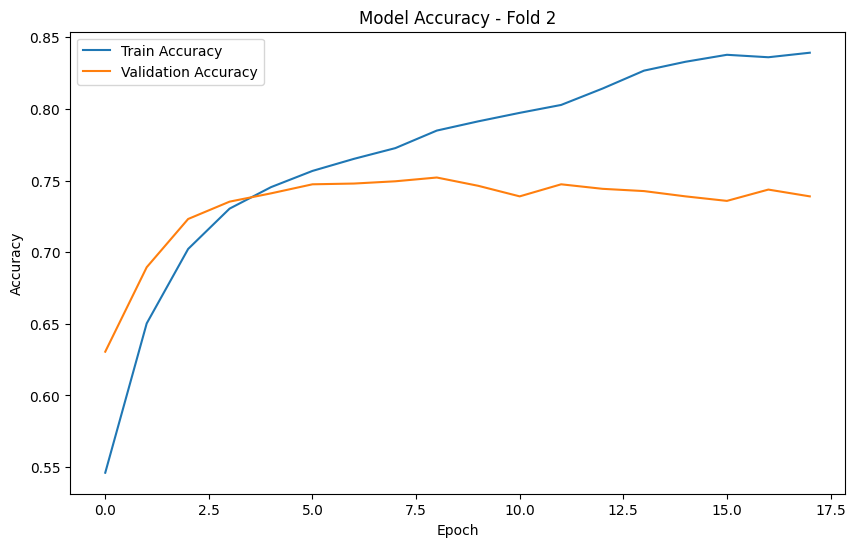

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-04-08 09:31:56.459984: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Fold 2 Results:
Accuracy: 0.7495
Balanced Accuracy: 0.7495
MCC: 0.5045
Sensitivity: 0.8232
Specificity: 0.6758

Fold 3/5
Epoch 1/50


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5187 - loss: 0.6892 - val_accuracy: 0.6474 - val_loss: 0.6364 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6697 - loss: 0.6159 - val_accuracy: 0.7047 - val_loss: 0.5782 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7319 - loss: 0.5457 - val_accuracy: 0.7132 - val_loss: 0.5573 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7539 - loss: 0.5242 - val_accuracy: 0.7247 - val_loss: 0.5452 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7586 - loss: 0.5085 - val_accuracy: 0.7242 - val_loss: 0.5394 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7644 - loss: 0.4979 - val_accuracy: 0.7332 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7773 - loss: 0.4844 - val_accurac

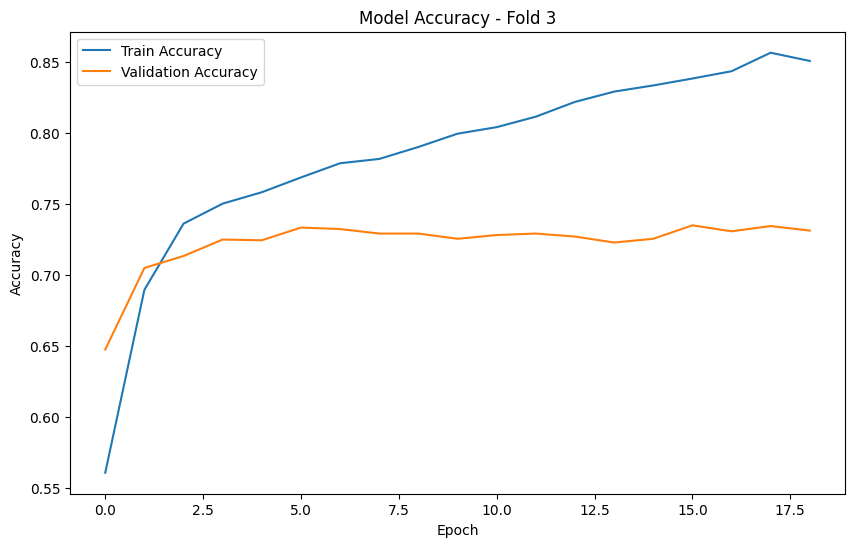

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-04-08 09:32:21.429224: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 3 Results:
Accuracy: 0.7289
Balanced Accuracy: 0.7289
MCC: 0.4579
Sensitivity: 0.7242
Specificity: 0.7337

Fold 4/5
Epoch 1/50


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 24/238 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5288 - loss: 0.6943  

E0000 00:00:1744104742.922147  843871 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_6_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5381 - loss: 0.6879 - val_accuracy: 0.6563 - val_loss: 0.6304 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6813 - loss: 0.6041 - val_accuracy: 0.7026 - val_loss: 0.5727 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7212 - loss: 0.5577 - val_accuracy: 0.7189 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7342 - loss: 0.5364 - val_accuracy: 0.7200 - val_loss: 0.5457 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7511 - loss: 0.5192 - val_accuracy: 0.7226 - val_loss: 0.5439 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7611 - loss: 0.5027 - val_accuracy: 0.7284 - val_loss: 0.5397 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7677 - loss: 0.4932 - val_accurac

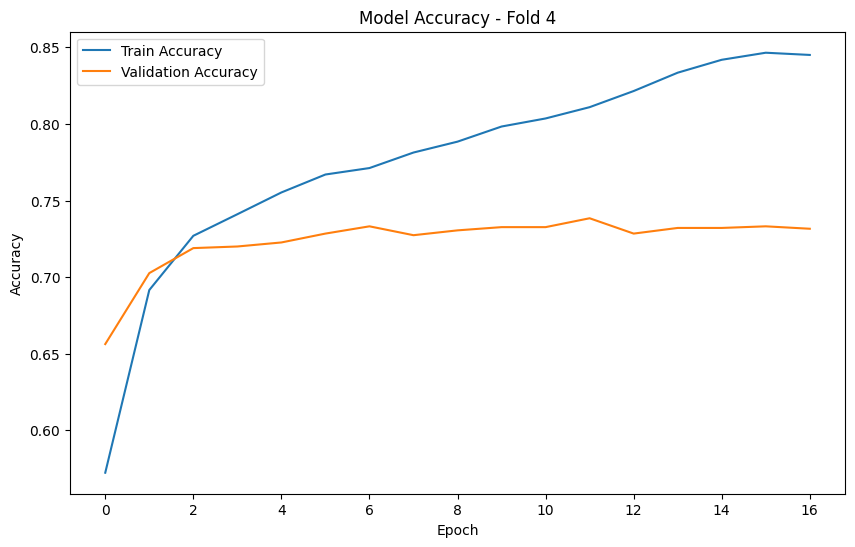

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-04-08 09:32:44.307617: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 4 Results:
Accuracy: 0.7332
Balanced Accuracy: 0.7332
MCC: 0.4666
Sensitivity: 0.7495
Specificity: 0.7168

Fold 5/5


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5280 - loss: 0.6899 - val_accuracy: 0.6547 - val_loss: 0.6325 - learning_rate: 0.0010
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6507 - loss: 0.6214 - val_accuracy: 0.7084 - val_loss: 0.5657 - learning_rate: 0.0010
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7217 - loss: 0.5621 - val_accuracy: 0.7200 - val_loss: 0.5458 - learning_rate: 0.0010
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7372 - loss: 0.5400 - val_accuracy: 0.7384 - val_loss: 0.5347 - learning_rate: 0.0010
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7563 - loss: 0.5204 - val_accuracy: 0.7321 - val_loss: 0.5335 - learning_rate: 0.0010
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7601 - loss: 0.5111 - val_accuracy: 0.7363 - val_loss: 0.5267 - learning_rate: 0.0010
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7649 - loss: 0.4979 - 

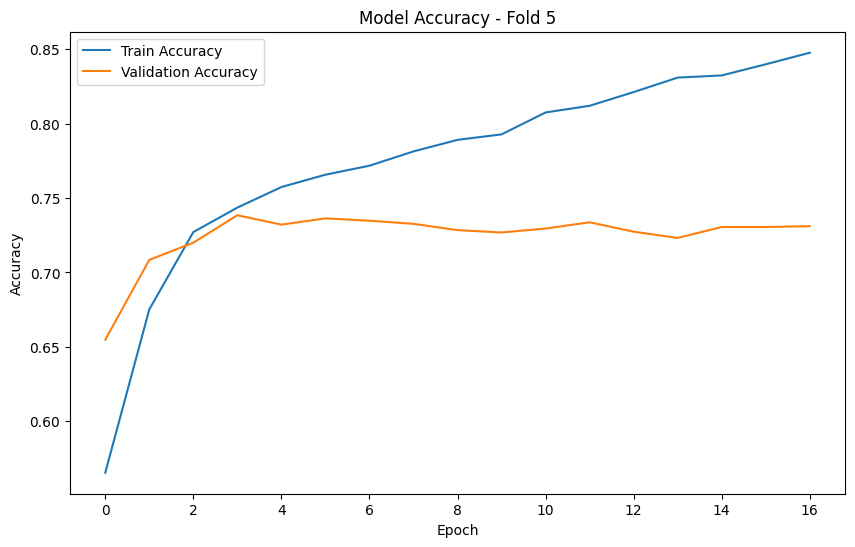

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-04-08 09:33:07.773802: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 5 Results:
Accuracy: 0.7347
Balanced Accuracy: 0.7347
MCC: 0.4696
Sensitivity: 0.7253
Specificity: 0.7442

Average Cross-validation Results:
ACC: 0.7375 ± 0.0072
BALANCED_ACC: 0.7375 ± 0.0072
MCC: 0.4762 ± 0.0162
SN: 0.7564 ± 0.0361
SP: 0.7185 ± 0.0234

Final Test Set Results:
Accuracy: 0.7066
Balanced Accuracy: 0.7287
MCC: 0.2609
Sensitivity: 0.7549
Specificity: 0.7025
Confusion Matrix:
[[2087  884]
 [  62  191]]


In [ ]:
model, test_probs = train_and_evaluate_seq_only()